# Práctico 1: Introducción al aprendizaje por refuerzos
## Integrantes:
    Analian
    Kraupl
    Piaggio
    
Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2019


## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, dada por $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{a'}e^{Q(s,a')/\tau}}$$



Para dejar el lab listo para su corrección, dejar link a repo de github con un notebook ejecutando el agente en la planilla enviada en Slack.

- NOTA: Los ejercicios no están desarrollados en el mismo orden que la lista de actividades (pero están todos, posta ;) )

## The Cliff. 


![](images/cliffwalking.png)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* ^ - Arriba
* v - Abajo
* \> - Derecha
* < - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados 
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

In [2]:
import matplotlib.pyplot as plt
import itertools
import gym
import numpy as np
from agents.utils.plotting import plot_reward_per_episode, plot_steps_per_episode, plot_steps_per_episode_smooth, draw_value_matrix

## e-Greedy 
Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [3]:
def choose_action_egreedy(state, actions, q, epsilon, random_state):
    """
    Chooses an action according to the learning previously performed
    using an epsilon-greedy exploration policy
    """
    # q.get((state, a), 0.0) toma el valor de la tupla estado accion y en caso de no devolver, pone 0.0
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)

    if random_state.uniform() < epsilon:
        return random_state.choice(actions)  # a random action is selected

    count = q_values.count(max_q)

    # In case there're several state-action max values
    # we select a random one among them
    if count > 1:
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        i = q_values.index(max_q)

    return actions[i]

## 4. Implementación de Softmax 
 $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{a'}e^{Q(s,a')/\tau}}$$

In [4]:
def choose_action_softmax(state, actions, q, tau, random_state):
    """
    Chooses an action according to the learning previously performed
    using softmax policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]
    numerador = [np.exp(valor / tau) for valor in q_values]
    denominador = sum(numerador)

    softmax = [item / denominador for item in numerador]
    # armamos un array acumulando cada valor anterior
    acum = np.cumsum(softmax)
    rnd_val = random_state.uniform()

    for i in range(len(actions)):
        if acum[i] >= rnd_val:
            action = actions[i]
            break

    return action

### 1.1 implementación SARSA
Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [5]:
def learn_sarsa(state, action, q, reward, next_state, next_action, alpha, gamma):
    """
    Performs a SARSA update for a given state transition
    """
    # incorporar el estado al diccionario si no está o actualizar el valor siguiendo la formula de SARSA.
    # alpha = 0.5
    # gamma = 1
    # epsilon = 0.1
    # calcular y actualizar Q(s,a) = Q(s,a) + alpha * (reward + (gamma * Q(s',a') ) - Q(s,a) )

    q_actual = q.get((state, action), 0.0)  # Q(s,a)
    q_prima = q.get((next_state, next_action), 0.0)  # Q(s',a')

    prediccion = reward + gamma * q_prima  # prediccion =  (reward + (gamma * Q(s',a') )

    # tiene que actualizar el diccionario Q (no devuelve nada)
    q[state, action] = q_actual + alpha * (prediccion - q_actual)
    pass

### 2.1 implementacion Q-Learn

![](images/QLearningUpdate.png)

In [6]:
def learn_q_learn(state, action, actions, q, reward, next_state, next_action, alpha, gamma):
    """
        Performs a Q-learn update for a given state transition
        """
    # incorporar el estado al diccionario si no está o actualizar el valor siguiendo la formula de SARSA.
    # alpha = 0.5
    # gamma = 1
    # epsilon = 0.1
    # calcular y actualizar Q(s,a) = Q(s,a) + alpha * (reward + (gamma * max(a)Q(s',a) ) - Q(s,a) )

    q_actual = q.get((state, action), 0.0)  # Q(s,a)

    # busca la mejor politica (maximo valor) pero no está obligado a usarla
    max_actions = [q.get((next_state, a), 0.0) for a in actions]
    max_action = max(max_actions)

    prediccion = reward + gamma * max_action  # prediccion =  (reward + (gamma * Q(s',a) )
    # tiene que actualizar el diccionario Q (no devuelve nada)
    q[state, action] = q_actual + alpha * (prediccion - q_actual)

    pass

## Metodo principal
Finalmente, definimos el método principal de iteraciones. 

In [7]:
def run(episodes_to_run, choose_action_mode, learn_mode, alpha, gamma, epsilon, tau= 0):
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    env = gym.make("CliffWalking-v0")

    actions = range(env.action_space.n)
    q = {}  # matriz
    random_state = np.random.RandomState(42)
    next_action = 0
    action = 0

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        # ==========================================================================================
        if (choose_action_mode == 'e-greedy'):
            action = choose_action_egreedy(state, actions, q, epsilon, random_state)
        if (choose_action_mode == 'softmax'):
            action = choose_action_softmax(state, actions, q, tau, random_state)
        # ==========================================================================================

        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)

            # next_action = Pick an action based on the current state
            # ==========================================================================================
            if (choose_action_mode == 'e-greedy'):
                next_action = choose_action_egreedy(next_state, actions, q, epsilon, random_state)
            if (choose_action_mode == 'softmax'):
                next_action = choose_action_softmax(next_state, actions, q, tau, random_state)
            # ==========================================================================================

            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps

                # actualizamos la matriz segun el metodo
                # ==========================================================================================
                if (learn_mode == 'sarsa'):
                    learn_sarsa(state, action, q, reward, next_state, next_action, alpha, gamma)
                if (learn_mode == 'q-learn'):
                    learn_q_learn(state, action, actions, q, reward, next_state, next_action, alpha, gamma)
                # ==========================================================================================

                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)

                # actualizamos la matriz segun el metodo
                # ==========================================================================================
                if (learn_mode == 'sarsa'):
                    learn_sarsa(state, action, q, reward, next_state, next_action, alpha, gamma)
                if (learn_mode == 'q-learn'):
                    learn_q_learn(state, action, actions, q, reward, next_state, next_action, alpha, gamma)
                # ==========================================================================================

                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1
    env.close()     
    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode, q

### 1.2 Ejecución con SARSA
Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [8]:
episodes_to_run = 1000
# epsilon - explora el % de las veces (float)
# tau = utilizado para el softmax

# definimos sus híper-parámetros básicos, y ejecutamos nuestro agente
avg_steps_per_episode, timesteps_ep, reward_ep , q = run(episodes_to_run,'e-greedy','sarsa', alpha=0.99, gamma=1, epsilon=0.3) 

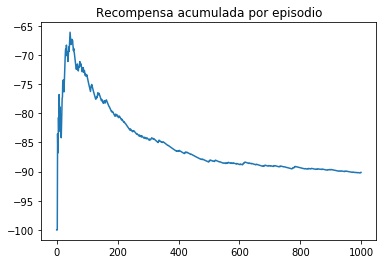

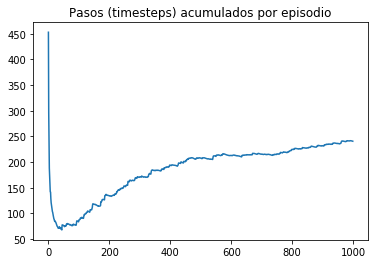

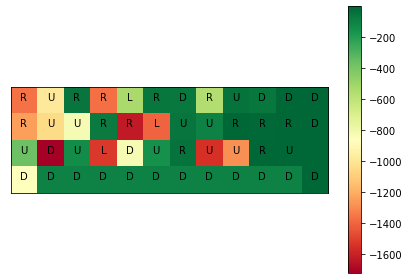


 Matriz de mejor acción-valor (en números): 

 [[-1.36146393e+03 -9.82941101e+02 -5.44415910e+01 -1.36891473e+03
  -5.29299621e+02 -5.52448948e+01 -6.40318358e+01 -5.57973035e+02
  -4.48041408e+01 -5.79041422e+01 -4.00091356e+00 -3.19106913e+00]
 [-1.23896780e+03 -1.04570890e+03 -8.26714044e+02 -7.18828291e+01
  -1.62160934e+03 -1.40146909e+03 -5.15929563e+01 -9.59451127e+01
  -5.33034247e+00 -7.85105226e+00 -3.00000051e+00 -2.00000000e+00]
 [-3.70303626e+02 -1.72183235e+03 -1.33809035e+02 -1.52262322e+03
  -8.24676104e+02 -1.49797307e+02 -4.25926134e+01 -1.55275832e+03
  -1.27959862e+03 -6.64843065e+00 -4.00966614e+00 -1.00000000e+00]
 [-8.64891654e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
  -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
  -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+00]]


In [9]:
plot_reward_per_episode(reward_ep) 
plot_steps_per_episode_smooth(timesteps_ep)
draw_value_matrix(q)

### 2.2 Ejecución de Q-Learn

In [12]:
avg_steps_per_episode, timesteps_ep, reward_ep , q = run(episodes_to_run,'e-greedy','q-learn', alpha=0.99, gamma=1, epsilon=0.3) 

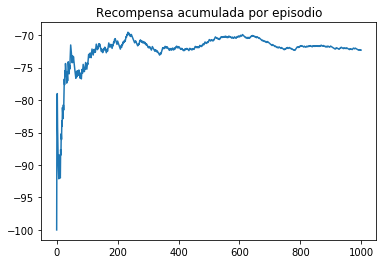

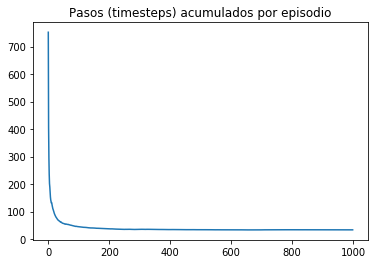

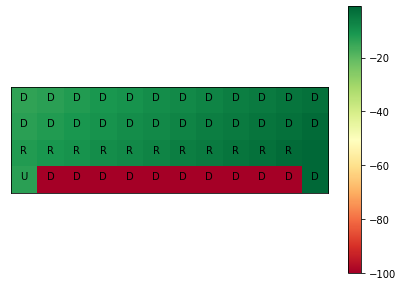


 Matriz de mejor acción-valor (en números): 

 [[ -14.  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.]
 [ -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.]
 [ -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.]
 [ -13. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


In [13]:
plot_reward_per_episode(reward_ep) 
plot_steps_per_episode_smooth(timesteps_ep)
draw_value_matrix(q)

### 2.3 ¿Cómo converge Q-Learn con respecto a SARSA? ¿A qué se debe?
El algoritmo Q-Learn tiene una velocidad de convergencia mayor al SARSA, dado a la forma en que actualiza el valor de Q.
Se debe a que Q-Learn al actualizar el valor Q, asume que a partir del próximo estado, se tomará la mejor acción posible.
En este tipo de ejemplo, SARSA tiende a ser mas conservador mientras que Q-Learn busca caminos óptimos.

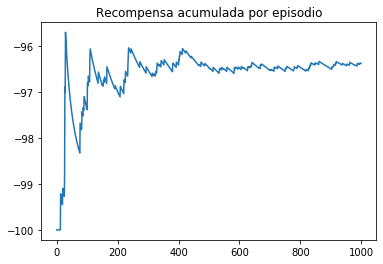

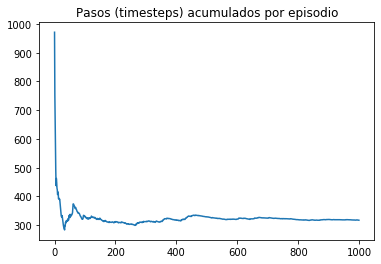

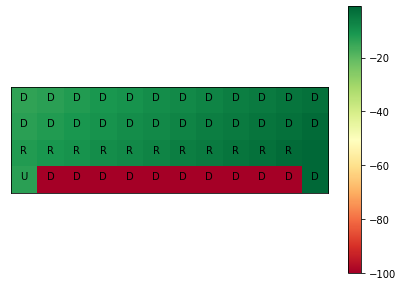


 Matriz de mejor acción-valor (en números): 

 [[ -14.  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.]
 [ -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.]
 [ -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.]
 [ -13. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


In [15]:
avg_steps_per_episode, timesteps_ep, reward_ep , q = run(episodes_to_run,'softmax','q-learn', alpha=0.99, gamma=1, epsilon=0.3, tau=25) 
plot_reward_per_episode(reward_ep) 
plot_steps_per_episode_smooth(timesteps_ep)
draw_value_matrix(q)

### 3 Exploración de hiperparámetros

#### Epsilon

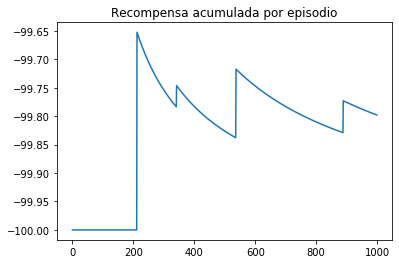

In [16]:
avg_steps_per_episode, timesteps_ep, reward_ep , q = run(episodes_to_run,'e-greedy','q-learn', alpha=1, gamma=1, epsilon=0.9) 
plot_reward_per_episode(reward_ep) 

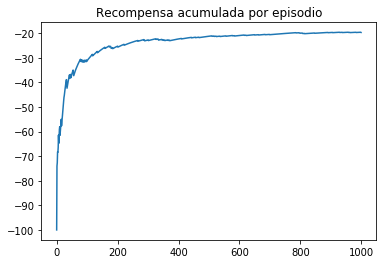

In [17]:
avg_steps_per_episode, timesteps_ep, reward_ep , q = run(episodes_to_run,'e-greedy','q-learn', alpha=1, gamma=1, epsilon=0.02) 
plot_reward_per_episode(reward_ep) 

##### Variación de epsilon
Incrementando el epsilon (probabilidad de que explore y no explote) vemos que la recompensa acumulada tienede a oscilar en valores muy bajos y no muestra mejora sostenida a lo largo de los episodios de corrida. Con un epsilon de 0.9 el 90% de las veces el algoritmo optaba por explorar en vez de explotar de acuerdo al valor Q. Esto hace que las acciones fueran mayormente aleatorias y por ende no aprovechava el aprendizaje. 


#### Alfa

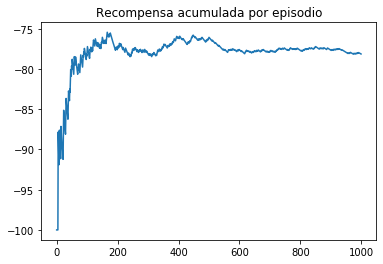

In [11]:
avg_steps_per_episode, timesteps_ep, reward_ep , q = run(episodes_to_run,'e-greedy','q-learn', alpha=1, gamma=1, epsilon=0.35) 
plot_reward_per_episode(reward_ep) 

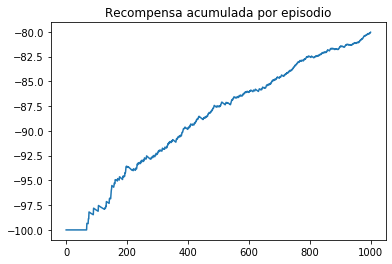

In [12]:
avg_steps_per_episode, timesteps_ep, reward_ep , q = run(episodes_to_run,'e-greedy','q-learn', alpha=0.01, gamma=1, epsilon=0.35) 
plot_reward_per_episode(reward_ep) 

Al dimsinuir el valore de alfa necesitamos mayor cantidad de episodios para converger. Para esto prbamos en la celda de abajo con 5000 episodios y se ve un valor de convergencia similar al del caso de alfa = 1, pero con menor oscilacion entre episodios. 

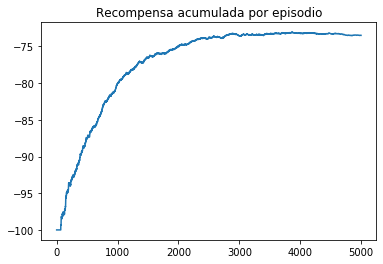

In [20]:
avg_steps_per_episode, timesteps_ep, reward_ep , q = run(5000,'e-greedy','q-learn', alpha=0.01, gamma=1, epsilon=0.35) 
plot_reward_per_episode(reward_ep) 

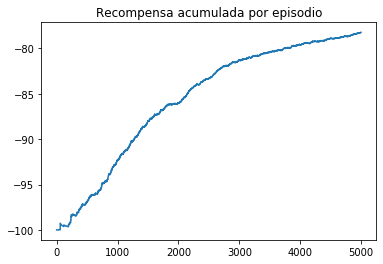

In [13]:
avg_steps_per_episode, timesteps_ep, reward_ep , q = run(5000,'e-greedy','q-learn', alpha=0.01, gamma=0.1, epsilon=0.35) 
plot_reward_per_episode(reward_ep) 

Al disminuir el valor de gama, vemos como se penaliza el aprendizaje del próximo estado.